In [86]:
import numpy as np
import pandas as pd
import random

In [20]:
df = pd.read_csv('./data/soc-redditHyperlinks-body.tsv', sep='\t')
df['NODE_ID'] = df['SOURCE_SUBREDDIT'] + '_' + df['TARGET_SUBREDDIT']
df['TIMESTAMP'] =  pd.to_datetime(df['TIMESTAMP'], infer_datetime_format=True)

In [21]:
df.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,NODE_ID
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",leagueoflegends_teamredditteams
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",theredlion_soccer
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",inlandempire_bikela
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",nfl_cfb
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",playmygame_gamedev


- number of links > number of unique posts meaning some posts have multiple hyperlinks
- number of unique source to target subreddits << number of unique nodes
- nodes = subreddits, edges = hyperlink, weight = number of posts that linked

In [13]:
print ('number of unique posts {0}'.format(len(np.unique(df['POST_ID']))))

number of unique posts 259092


In [14]:
print ('number of links {0}'.format(len(df)))

number of links 286561


In [17]:
print ('number of unique node ids {0}'.format(len(np.unique(df['NODE_ID']))))

number of unique node ids 137821


In [77]:
print ('number of unique subreddits {0}'.format(len(np.unique(df['SOURCE_SUBREDDIT'] + df['TARGET_SUBREDDIT']))))

number of unique subreddits 137820


- about 3-years worth of hyperlink data collected from December 31st, 2013 to April 30th, 2017

In [22]:
print ('time range {0} - {1}'.format(df['TIMESTAMP'].min(), df['TIMESTAMP'].max()))

time range 2013-12-31 16:39:58 - 2017-04-30 16:58:21


- calculate edge weight - number of posts containing a hyperlink between two subreddits
- most subreddits about 1-2 links between them, but some contain hundreds
- some subreddits are much more popular than others
- min = 1, max = 548, mean = 2

In [58]:
weighted_df = df.groupby(['NODE_ID']).size().reset_index(name='weight')
weighted_df['weight'].describe()

count    137821.000000
mean          2.079226
std           5.495717
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         548.000000
Name: weight, dtype: float64

In [66]:
print ('len after grouping {0}'.format(len(weighted_df)))
weighted_df.sort_values(['weight'], ascending=False).head()

len after grouping 137821


,NODE_ID,weight
128037,trendingsubreddits_changelog,548
114896,streetfighter_sf4,279
19991,buildapc_buildapcforme,244
80234,mushroomkingdom_gamesale,243
17348,bluejackets_bluejacketsgwg,223


In [72]:
merged_df = pd.merge(weighted_df, df, how='inner').sort_values(['TIMESTAMP'], ascending=True)
print (len(merged_df))
merged_df.head()

286561


,NODE_ID,weight,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,YEAR
145360,leagueoflegends_teamredditteams,39,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",2013
174067,nfl_cfb,14,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",2013
259858,theredlion_soccer,1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",2013
82626,dogemarket_dogecoin,71,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0...",2013
113100,gfycat_india,1,gfycat,india,1u5df2s,2013-12-31 22:27:50,1,"2849.0,2467.0,0.704106704107,0.00737100737101,...",2013


- How to split train and test data?
- By timestamp? train = links created from 2013 - 2016, test = links created in 2017
- Disregard when link was created - train = 80% of links and test = 20% (randomly removed)

### Create a directed, weighted graph from links

In [260]:
import networkx as nx

G = nx.from_pandas_edgelist(merged_df,
                            "SOURCE_SUBREDDIT",
                            "TARGET_SUBREDDIT",
                            ["POST_ID", "TIMESTAMP", "LINK_SENTIMENT", "weight"],
                           create_using=nx.Graph())

### Remove nodes with less than 5 connections

In [261]:
print ('graph size before filter {0}'.format(G.size()))
remove = [node for node, degree in dict(G.degree()).items() if degree <= 25]
G.remove_nodes_from(remove)
print ('graph size after filter {0}'.format(G.size()))
print (G)

graph size before filter 124330
graph size after filter 42669
Graph with 1682 nodes and 42669 edges


### Randomly sample edges to remove from the graph

In [262]:
total_size = len(G.edges())
sample_size = 0.2 * total_size
print ('total size {0}, sample size {1}'.format(total_size, sample_size))
test = random.sample(G.edges(), int(sample_size))
print ('sample from test set {0}'.format(test[:10]))

total size 42669, sample size 8533.800000000001
sample from test set [('askhistorians', 'askpsychology'), ('kendricklamar', 'runthejewels'), ('nofap', 'nudism'), ('randomactsofgaming', 'uncensorednews'), ('lakers', 'pacers'), ('newjersey', 'blog'), ('relationships', 'nursing'), ('copypasta', 'psychonaut'), ('sex', 'bisexual'), ('theredpill', 'csshelp')]


/var/folders/3q/3y2s7qxs3nl50c84jp8_80v00000gn/T/ipykernel_4793/282736771.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test = random.sample(G.edges(), int(sample_size))


### Create train set

In [263]:
print ('size of original {0}'.format(G.size()))
G.remove_edges_from(test)
print ('size of train {0}'.format(G.size()))

size of original 42669
size of train 34136


### Detect communities in training set
- Resolution: 1, 20 communities, max size = 358
- Resolution: 5, 103 communities, max size = 53
- Resolution: 3, 57 communities, max size = 99

In [264]:
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G, weight='weight', resolution=3))

In [265]:
print ('Found {0} communities'.format(len(communities)))
print ('Largest community has {0} nodes'.format(len(communities[0])))
print ('Smallest community has {0} nodes'.format(len(communities[-1])))

Found 57 communities
Largest community has 106 nodes
Smallest community has 1 nodes


In [266]:
total = 0
for community in communities:
    total += len(community)

print ('Total nodes across all communities = {0}'.format(total))
print ('Largest community accounted for {0}% of nodes'.format(len(communities[0]) / total * 100))
print ('Smallest community accounted for {0}% of nodes'.format(len(communities[-1]) / total * 100))
print ('Midsize community accounted for {0}% of nodes'.format(len(communities[20]) / total * 100))

Total nodes across all communities = 1682
Largest community accounted for 6.302021403091558% of nodes
Smallest community accounted for 0.05945303210463733% of nodes
Midsize community accounted for 1.7241379310344827% of nodes


### Inspect a few communities manually

- Community #25 (size = 29): religion and philosophy (catholicism, atheism, christianity, judaism, etc..)
- trueatheism, truechristian, brokehugs, reformed, atheism, mormon, latterdaysaints, debateanatheist, academicbiblical, magicskyfairy, hinduism, standupshots, religion, debateachristian, islam, badphilosophy, philosophy, exjw, catholicism, mildredditdrama, judaism, exchristian, bad_religion, debatereligion, christianity, askphilosophy, exmormon, modelusgovverify, exmuslim

- Community #10 (size = 48): gaming, electronics, gifts (randomactsofgaming, gamedeals, gamesale, etc..)
- patientgamers, washingtondc, giftcardexchange, pkmntcgreferences, randomactsofgaming, comcast, electronic_cigarette, redditbay, phoenix, random_acts_of_pizza, randomkindness, gamedeals, sacramento, dogs, giftofgames, shouldibuythisgame, mushroomkingdom, santaslittlehelpers, subredditads, cats, gamedealsmeta, gamecollecting, dogtraining, badkarma, nova, xcom, connecticut, borrow, randomactsofpizza, diy_ejuice, totalwar, golf, gamesale, tropicalweather, homeless, freebies, assistance, baltimore, randomactsofchristmas, orlando, trade, newjersey, askvet, atlanta, randomactsofcards, ecigclassifieds, pets, pittsburgh
- dogs and cats for some reason?

- Community #0 (size = 99): mental illness, psychology, advice, relationships
- mental illness: ocd, suicidewatch, bipolarreddit
- relationships: relationships, divorce, dating_advice
- advice: needadvice, legaladvice, askwomenadvice

- bipolarreddit, justnomil, ocd, foreveralone, suicidewatch, needafriend, trueoffmychest, personalfinancecanada, socialanxiety, askcarsales, stocks, exnocontact, legaladviceofftopic, decidingtobebetter, polyamory, dating_advice, bisexual, amitheasshole, amiugly, schizophrenia, legal, financialindependence, askleo, sanctionedsuicide, brdapublic, roadcam, relationships, mentalhealth, gaybros, infertility, advice, divorce, mmfb, askdocs, neuro, raisedbynarcissists, aspergers, insurance, babybumps, prorevenge, bpd, psychology, college, sex, bipolar, realestate, pettyrevenge, actuallesbians, depression, tryingforababy, weddingplanning, childfree, beyondthebump, legaladviceuk, lgbt, teachers, medical, anxiety, diabetes, getting_over_it, askwomenadvice, wallstreetbets, autism, bestoflegaladvice, malehairadvice, daddit, scams, parenting, socialskills, churning, sexover30, universityofreddit, confession, relationship_advice, needadvice, chronicpain, abuseinterrupted, ptsd, lgbteens, askpsychology, longdistance, nursing, hawaii, breakingmom, offmychest, investing, askacademia, adhd, gradschool, ontario, personalfinance, selfharm, legaladvice, engineeringstudents, howtonotgiveafuck, dentistry, askgaybros, teenagers, psychiatry

- Community #57, #56 (size = 1) lordsofminecraft, smutbuddy
- A marketplace for selling minecraft items?
- This subreddit does not have any significant links to other subreddits on the site, meaning users who post here don't interact much with users outside of the community?

In [271]:
print (', '.join(list(communities[-1])))

smutbuddy


### Add community property to nodes

In [272]:
for index in range(len(communities)):
    community = communities[index]
    for subreddit in community:
        G.nodes[subreddit]['community'] = str(index)

In [273]:
print (list(G.nodes(data=True))[:10])

[('leagueoflegends', {'community': '4'}), ('nfl', {'community': '15'}), ('cfb', {'community': '23'}), ('soccer', {'community': '33'}), ('dogemarket', {'community': '8'}), ('dogecoin', {'community': '8'}), ('gfycat', {'community': '33'}), ('india', {'community': '14'}), ('playmygame', {'community': '1'}), ('gamedev', {'community': '1'})]


### Make predictions

In [274]:
predicted_wic = list(nx.within_inter_cluster(G, test))

In [275]:
print ('Number of predictions (positive links) {0}'.format(len(predicted_wic)))

Number of predictions (positive links) 8533


In [290]:
import warnings
warnings.filterwarnings("ignore")

test_negative = []
for i in range(len(test)):
    n1 = random.sample(G.nodes(), 1)[0]
    n2 = random.sample(G.nodes(), 1)[0]
    
    while (G.has_edge(n1, n2)):
        n1 = random.sample(G.nodes(), 1)[0]
        n2 = random.sample(G.nodes(), 1)[0]

    test_negative.append((n1, n2))

In [291]:
predicted_wic_negative = list(nx.within_inter_cluster(G, test_negative))

### Correctly-predicted links
- 'buccaneers', 'greenbaypackers', 16000
- 'cardinals', 'nationals', 3000
- 'entp', 'mbti', 3000
- 'exchristian', 'debateanatheist', 2000
- 'pokemontrades', 'pokemonplaza', 2000

### Links that were missed
- 'offmychest', 'unpopularopinion', 0
- 'subredditdrama', 'vegetarian', 0
- 'dataisbeautiful', 'bestofoutrageculture', 0
- 'mechanicalkeyboards', 'hardware', 0

### Links that were often missed were from more niche, less popular subreddits?

In [292]:
ground_truth = ([1] * len(test)) + ([0] * len(test))
print (sum(ground_truth) / len(ground_truth))

0.5


In [294]:
preds = []

for wic in predicted_wic:
    if wic[-1] > 0:
        preds.append(1)
    else:
        preds.append(0)
        
for wic in predicted_wic_negative:
    if wic[-1] > 0:
        preds.append(1)
    else:
        preds.append(0)

array([[8399,  134],
       [7238, 1295]])

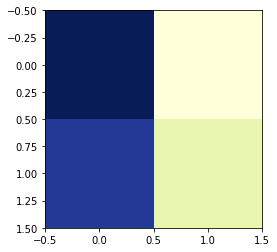

In [304]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(ground_truth, preds), cmap="YlGnBu")
confusion_matrix(ground_truth, preds)

- Recall = ability of classifier to predict actual links
- Recall = 0.5371 -> not very good at predicting future links (moderate-to-low recall)

In [305]:
recall = 8399.0 / (8399.0 + 7238.0)
print (recall)

0.5371234891603248


- Precision = ability of classifier to avoid false positives
- Precision = 0.98 -> very good, when the classifier says a link doesn't exist it probably doesn't

In [306]:
precision = 8399.0 / (8399.0 + 134.0)
print (precision)

0.9842962615727177


### Conclusions
- Lower community resolution led to better accuracy in link prediction but more undefined communities
    - 32.6% with R = 1 and 11% with R = 3
- Less culling led to slightly higher accuracy but not much, and was much slower to calculate
    - Degree >= 5, R = 1 -> 39.74% acc
    - Degree >= 25, R = 1 -> 32.6% acc
- Discarding edge weights when detectecting communities also had a slightly higher accuracy
    - weighted edges, R = 3 -> 11%
    - non-weighted edges, R = 3 -> 14.7%
    
- A lot more difficult to correcly predict new links, the classifier was much better at avoiding false positives. Community-based detection was moderately good at finding new links but had a much higher precision, meaning it was much more likely to avoid recommending a subreddit that isn't related